In [432]:
import datetime

import matplotlib as mp
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt


sns.set()
sns.set_style('whitegrid')
sns.set_style('ticks')

# data

In [6]:
# https://data.sfgov.org/Housing-and-Buildings/Planning-Department-Records/7yuw-98m5
# csv: https://data.sfgov.org/api/views/kgai-svwy/rows.csv?accessType=DOWNLOAD
# glossary: http://default.sfplanning.org/GIS/DataSF_PPTS_Fields.xlsx

fields = pd.read_csv('planning-department-records/DataSF_PPTS_Fields.csv')
data = pd.read_csv('planning-department-records/PPTS_Records_data.csv',
                   parse_dates=[
                       'date_opened',
                       'date_closed',
                   ],
                   infer_datetime_format=True)

In [32]:
# prj is a decent first-approximation of the first time planning learns about a project
prj = data[data['record_type_category'] == 'PRJ']

In [101]:
# Find all projects with any units proposed
market_res_units = [
    'PRJ_FEATURE_MARKET_RATE_EXIST',
    'PRJ_FEATURE_MARKET_RATE_PROP',
    'PRJ_FEATURE_MARKET_RATE_NET',
]
aff_res_units = [
    'PRJ_FEATURE_AFFORDABLE_EXIST',
    'PRJ_FEATURE_AFFORDABLE_PROP',
    'PRJ_FEATURE_AFFORDABLE_NET',
]

res_units = market_res_units + aff_res_units

q = ~pd.isna(prj[res_units[0]])
for r in res_units[1:]:
    q |= ~pd.isna(prj[r])
prj_res = prj[q]

In [108]:
# Unfortunately, planning is missing data for anything before 2014 Q4
prj_res = prj_res[prj_res.date_opened >= datetime.datetime(2014,10,1)]

In [109]:
len(prj_res)

3531

In [160]:
def quarter(dt):
    return "%s Q%s" % (dt.year, int(np.ceil((dt.month-1)/3)) + 1)


def half(dt):
    return "%s H%s" % (dt.year, int(np.ceil((dt.month-1)/6)) + 1)


def monthyear(dt):
    return "%s %s" % (dt.year, dt.strftime("%b"))

In [161]:
prj_res['_year'] = prj_res['date_opened'].apply(lambda dt: str(dt.year))
prj_res['_quarter'] = prj_res['date_opened'].apply(quarter)
prj_res['_half'] = prj_res['date_opened'].apply(half)
prj_res['_month'] = prj_res['date_opened'].apply(monthyear)

# Analysis

In [347]:
before = prj_res[prj_res.date_opened < datetime.datetime(2016,7,1)]  # Before Prop C
after = prj_res[prj_res.date_opened >= datetime.datetime(2016,7,1)]  # After Prop C

## All projects with some market-rate units

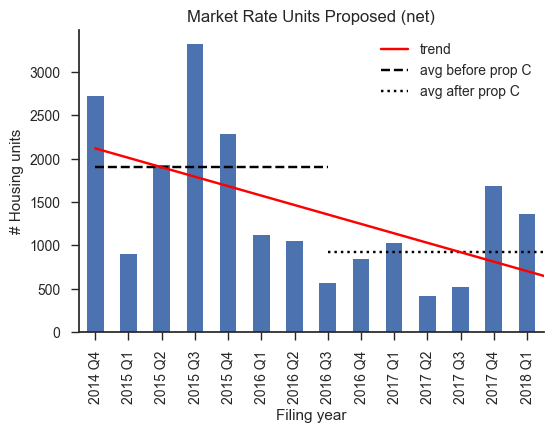

In [345]:
mrk_data = prj_res.groupby('_quarter').aggregate({'PRJ_FEATURE_MARKET_RATE_NET': 'sum'})
d = mrk_data.PRJ_FEATURE_MARKET_RATE_NET.values.tolist()
params = np.polyfit(range(len(d)), d, 1)
poly = np.poly1d(params)

mrk_data_before = before.groupby('_quarter').aggregate({'PRJ_FEATURE_MARKET_RATE_NET': 'sum'})
d = mrk_data_before.PRJ_FEATURE_MARKET_RATE_NET.values.tolist()
offset = len(d)
avg_before = np.mean(d)

mrk_data_after = after.groupby('_quarter').aggregate({'PRJ_FEATURE_MARKET_RATE_NET': 'sum'})
d = mrk_data_after.PRJ_FEATURE_MARKET_RATE_NET.values.tolist()
avg_after = np.mean(d)

f = mp.pyplot.figure()
ax = f.gca()
p = mrk_data.plot.bar(ax=ax)
p.set_label("_nolegend_")

xp = np.linspace(0, len(mrk_data.PRJ_FEATURE_MARKET_RATE_NET.values), 20)
l1 = ax.plot(xp, poly(xp), label='trend', color='red')
l2 = ax.hlines(avg_before, 0, offset, label='avg before', linestyles='dashed')
l3 = ax.hlines(avg_after, offset, len(d) + offset, label='avg after', linestyles='dotted')
mp.pyplot.title("Market Rate Units Proposed (net)")
ax.set_ylabel("# Housing units")
ax.set_xlabel("Filing year")
#ax.legend()
ax.legend((l1[0], l2, l3), ('trend', 'avg before prop C', 'avg after prop C'))
sns.despine()
f.set_dpi(100)
f.savefig("figs/market-rate-net.png", dpi=300, bbox_inches='tight')

## All Affordable units

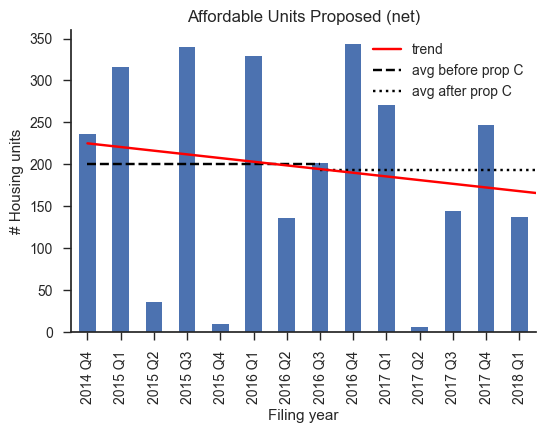

In [346]:
aff_data = prj_res.groupby('_quarter').aggregate({'PRJ_FEATURE_AFFORDABLE_NET': 'sum'})
d = aff_data.PRJ_FEATURE_AFFORDABLE_NET.values.tolist()
params = np.polyfit(range(len(d)), d, 1)
poly = np.poly1d(params)

aff_data_before = before.groupby('_quarter').aggregate({'PRJ_FEATURE_AFFORDABLE_NET': 'sum'})
d = aff_data_before.PRJ_FEATURE_AFFORDABLE_NET.values.tolist()
offset = len(d)
avg_before = np.mean(d)

aff_data_after = after.groupby('_quarter').aggregate({'PRJ_FEATURE_AFFORDABLE_NET': 'sum'})
d = aff_data_after.PRJ_FEATURE_AFFORDABLE_NET.values.tolist()
avg_after = np.mean(d)

f = mp.pyplot.figure()
ax = f.gca()
p = aff_data.plot.bar(ax=ax)
p.set_label("_nolegend_")

xp = np.linspace(0, len(aff_data.PRJ_FEATURE_AFFORDABLE_NET.values), 20)
l1 = ax.plot(xp, poly(xp), label='trend', color='red')
l2 = ax.hlines(avg_before, 0, offset, label='avg before', linestyles='dashed')
l3 = ax.hlines(avg_after, offset, len(d) + offset, label='avg after', linestyles='dotted')
mp.pyplot.title("Affordable Units Proposed (net)")
ax.set_ylabel("# Housing units")
ax.set_xlabel("Filing year")
#ax.legend()
ax.legend((l1[0], l2, l3), ('trend', 'avg before prop C', 'avg after prop C'))
sns.despine()

f.set_dpi(100)
f.savefig("figs/affordable-net.png", dpi=300, bbox_inches='tight')

## Break down by project type

The percentage of subsidized affordable units mandated by law varies according to the size of the project:

* Fewer than 10 units: 0%
* Fewer than 25 units: 12%
* 25 or more units: 20%

The old requirement was a flat 12% on projects with more than 10 units, so we can compare the classes of projects to get an estimate for the impact of Prop C.

In [352]:
def project_type(mrk_units):
    if not mrk_units:
        return "NA"
    if int(mrk_units) < 10:
        return "0"
    elif int(mrk_units) < 25:
        return "12"
    else:
        return "20"
    
prj_res['_project_type'] = prj_res[prj_res['PRJ_FEATURE_MARKET_RATE_NET']>0]['PRJ_FEATURE_MARKET_RATE_NET'].apply(project_type)

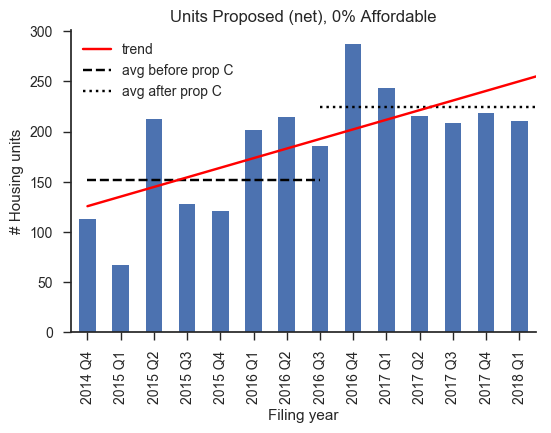

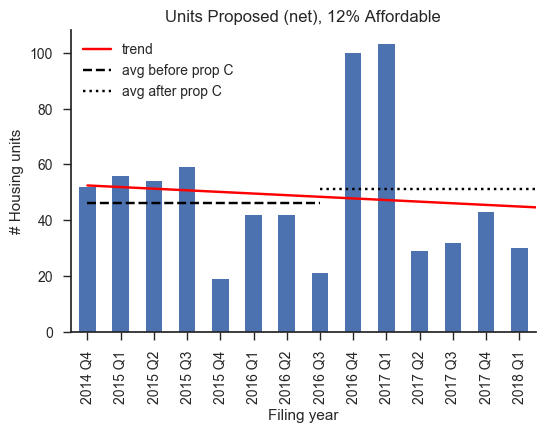

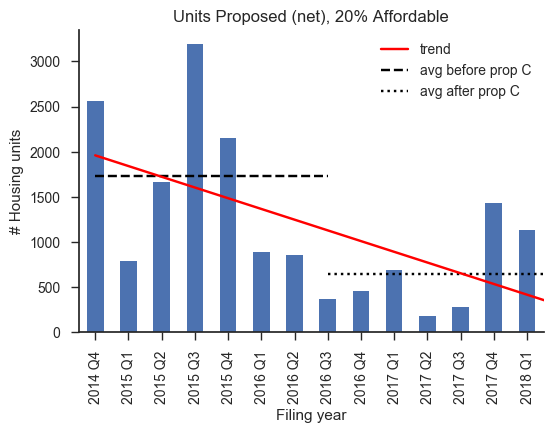

In [472]:
before = prj_res[prj_res.date_opened < datetime.datetime(2016,7,1)]  # Before Prop C
after = prj_res[prj_res.date_opened >= datetime.datetime(2016,7,1)]  # After Prop C

mrk_data = prj_res.groupby(['_quarter', '_project_type']).aggregate({'PRJ_FEATURE_MARKET_RATE_NET': 'sum'})
mrk_data_before = before.groupby(['_quarter', '_project_type']).aggregate({'PRJ_FEATURE_MARKET_RATE_NET': 'sum'})
mrk_data_after = after.groupby(['_quarter', '_project_type']).aggregate({'PRJ_FEATURE_MARKET_RATE_NET': 'sum'})

idx = pd.IndexSlice
for c, _project_type in enumerate(['0', '12', '20']):
    _mrk = mrk_data.loc[idx[:, _project_type], idx[:]]
    _mrk_before = mrk_data_before.loc[idx[:, _project_type], idx[:]]
    _mrk_after = mrk_data_after.loc[idx[:, _project_type], idx[:]]
    
    d = _mrk.PRJ_FEATURE_MARKET_RATE_NET.values.tolist()
    params = np.polyfit(range(len(d)), d, 1)
    poly = np.poly1d(params)

    d = _mrk_before.PRJ_FEATURE_MARKET_RATE_NET.values.tolist()
    offset = len(d)
    avg_before = np.mean(d)

    d = _mrk_after.PRJ_FEATURE_MARKET_RATE_NET.values.tolist()
    avg_after = np.mean(d)
    f = mp.pyplot.figure()
    ax = f.gca()
    #ax = axarr[c]
    p = _mrk.plot.bar(x=_mrk.index.levels[0], ax=ax)
    #p.set_label("_nolegend_")

    xp = np.linspace(0, len(_mrk.PRJ_FEATURE_MARKET_RATE_NET.values), 20)
    l1 = ax.plot(xp, poly(xp), label='trend', color='red')
    l2 = ax.hlines(avg_before, 0, offset, label='avg before', linestyles='dashed')
    l3 = ax.hlines(avg_after, offset, len(d) + offset, label='avg after', linestyles='dotted')
    ax.set_xlabel("%s%% Affordable" % _project_type)

    #ax.legend()
    mp.pyplot.title("Units Proposed (net), %s%% Affordable" % _project_type)
    ax.set_ylabel("# Housing units")
    ax.set_xlabel("Filing year")
    #ax.legend()
    ax.legend((l1[0], l2, l3), ('trend', 'avg before prop C', 'avg after prop C'))
    sns.despine()
    f.set_dpi(100)
    if c == 0:
        ax.legend((l1[0], l2, l3), ('trend', 'avg before prop C', 'avg after prop C'))
    sns.despine()
    f.set_dpi(100)
    f.savefig("figs/market-rate-net-%s-affordable.png" % _project_type, dpi=100, bbox_inches='tight')